In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env NOT_USE_CLOUD_LOGGER=False

env: NOT_USE_CLOUD_LOGGER=False


In [3]:
import sys
sys.path.append("../../cloud_functions/promo_effectiveness_tool/")

In [4]:
%env GOOGLE_APPLICATION_CREDENTIALS = /Users/451466/.config/gcloud/eads-pricing-nonprod-developer-credentials.json

env: GOOGLE_APPLICATION_CREDENTIALS=/Users/451466/.config/gcloud/eads-pricing-nonprod-developer-credentials.json


In [5]:
import pandas as pd
import numpy as np
from utils import get_df_from_select, replace_query
import matplotlib.pyplot as plt

/Users/451466/anaconda3/lib/python3.10/site-packages/snowflake/connector/options.py:108: UserWarning: You have an incompatible version of 'pyarrow' installed (12.0.1), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


In [10]:
# First round of analysis time horizon
# start_day = '2024-10-15'
# end_day = '2024-12-15'

# Update on Mar31 on partner discount breakdown
start_day = '2024-10-15'
end_day = '2025-03-30'


In [ ]:
# [NOTEBOOK_AGENT]: SQL in this cell was automatically translated.
query = f"""
```sql
with line_level_sls AS (
select
day_id, loc_group_id, loc_id, transaction_key, customer_id, employee_purchase_id, sls.sku_key, sku.sku_brand_desc,sku.OWNED_BRAND_FLAG, sku.DEPARTMENT_DESC,
CY_SALES_DOLLARS,
CY_RETAIL_SALES_DOLLARS,
CY_RETAIL_SALES_DOLLARS - CY_SALES_DOLLARS as total_discount,
GREATEST(ifnull(CY_MISC_DISCOUNT_AMOUNT, 0), 0) as CY_MISC_DISCOUNT_AMOUNT,
GREATEST(ifnull(cy_event_discount_amount, 0), 0) as cy_event_discount_amount,
GREATEST(ifnull(item_coupon_amt, 0), 0) as item_coupon_amt ,
GREATEST(ifnull(pals_rewards_coupon_discount, 0), 0) as pals_rewards_coupon_discount,
GREATEST(ifnull(EMPLOYEE_DISCOUNT_AMOUNT, 0), 0) as employee_discount_amount,
GREATEST(ifnull(MFR_PETCO_CPN_DISC , 0), 0) as manufacture_discouont_amount,

CASE WHEN employee_purchase_id <> 'NA' then 1 else 0 END AS purchase_by_partner,
CASE WHEN ifnull(EMPLOYEE_DISCOUNT_AMOUNT, 0) > 0 then 1 else 0 END AS partner_discount_flag,
CASE WHEN ifnull(item_coupon_amt, 0)-ifnull(pals_rewards_coupon_discount, 0) > 0 then 1 else 0 END as coupon_discount_flag,
CASE WHEN ifnull(cy_event_discount_amount, 0) >0 then 1 else 0 END as event_discount_flag,
CASE WHEN ifnull(item_coupon_amt, 0)-ifnull(pals_rewards_coupon_discount, 0) > 0  or cy_event_discount_amount>0 then 1 else 0 END as other_discount_flag

from `whprd_vw.dwadmin.ft_upc_sls` as sls
left join `WHPRD_VW.DWADMIN.LU_SKU` as sku on sls.sku_key = sku.sku_key
where 1=1
and day_id between CAST('{start_day}' AS DATE) and CAST('{end_day}' AS DATE)
AND RTN_FLAG = 'N'
and loc_group_id in ('S', 'I')
and CY_RETAIL_SALES_DOLLARS >= CY_SALES_DOLLARS
order by day_id
),

all_sls AS (
select purchase_by_partner, sku_brand_desc, loc_group_id,
sum(CY_SALES_DOLLARS) as total_sales,
sum(CY_RETAIL_SALES_DOLLARS) as total_retail_sales,
sum(CY_RETAIL_SALES_DOLLARS - CY_SALES_DOLLARS) as total_discount,
sum(pals_rewards_coupon_discount) AS total_reward_dollars,
sum(CY_RETAIL_SALES_DOLLARS - CY_SALES_DOLLARS - pals_rewards_coupon_discount) as total_discount_ex_pals_reward,
sum(CY_MISC_DISCOUNT_AMOUNT) as total_misc_discount,
sum(cy_event_discount_amount) as total_event_discount,
sum(item_coupon_amt) as total_item_coupon_discount,
sum(item_coupon_amt-pals_rewards_coupon_discount) as total_net_coupon_discount,
sum(EMPLOYEE_DISCOUNT_AMOUNT) as total_partner_discount,
sum(manufacture_discouont_amount) as total_manufacture_discount
from line_level_sls
group by 1, 2, 3
),

partner_sls AS (
select loc_group_id, partner_discount_flag, other_discount_flag, sku_brand_desc, OWNED_BRAND_FLAG, DEPARTMENT_DESC,
sum(CY_SALES_DOLLARS) as total_sales,
sum(CY_RETAIL_SALES_DOLLARS) as total_retail_sales,
sum(CY_RETAIL_SALES_DOLLARS - CY_SALES_DOLLARS) as total_discount,
sum(pals_rewards_coupon_discount) AS total_reward_dollars,
sum(CY_RETAIL_SALES_DOLLARS - CY_SALES_DOLLARS - pals_rewards_coupon_discount) as total_discount_ex_pals_reward,
sum(CY_MISC_DISCOUNT_AMOUNT) as total_misc_discount,
sum(cy_event_discount_amount) as total_event_discount,
sum(item_coupon_amt) as total_item_coupon_discount,
sum(item_coupon_amt-pals_rewards_coupon_discount) as total_net_coupon_discount,
sum(EMPLOYEE_DISCOUNT_AMOUNT) as total_partner_discount,
sum(manufacture_discouont_amount) as total_manufacture_discount
from line_level_sls
where purchase_by_partner = 1
group by 1, 2, 3, 4, 5, 6
)

select * from partner_sls
```
"""


In [12]:
df = get_df_from_select(query, False)
df

INFO | __init__ | Snowflake Connector for Python Version: 3.0.4, Python Version: 3.10.9, Platform: macOS-13.4-arm64-arm-64bit
INFO | __config | This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO | execute | query: [-- Following Ben's suggestion: -- 1. use sep-nov to exclude EDLP -- 2. exclude p...]


/Users/451466/vscode_projects/eads-pricing/notebooks/shuang/../../cloud_functions/promo_effectiveness_tool/utils.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query_template_or_file, conn)


INFO | execute | query execution done
INFO | _init_result_and_meta | Number of results in first chunk: 547


,loc_group_id,partner_discount_flag,other_discount_flag,sku_brand_desc,total_sales,total_retail_sales,total_discount,total_reward_dollars,total_discount_ex_pals_reward,total_misc_discount,total_event_discount,total_item_coupon_discount,total_net_coupon_discount,total_partner_discount,total_manufacture_discount
0,S,1,0,KAYTEE,129128.93,167290.12,38161.19,4847.89,33313.30,33496.99,0.00,4664.20,-183.69,33496.99,1781.38
1,S,0,1,SOULISTIC,108.96,1236.48,1127.52,54.33,1073.19,179.09,877.55,70.88,16.55,0.00,114.05
2,S,1,0,FRISKIES,116844.22,150462.15,33617.93,3890.77,29727.16,30166.33,0.00,3451.61,-439.16,30166.33,1276.34
3,S,1,1,BETTER BELLY,16553.57,48504.48,31950.91,2380.24,29570.67,4817.34,24471.70,2661.87,281.63,4817.34,612.27
4,S,1,1,FLUVAL,50584.02,93484.13,42900.11,2882.03,40018.08,15093.23,18108.98,9697.90,6815.87,15093.23,101.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,S,1,1,HUNGER FOR WORDS,39.47,83.97,44.50,2.89,41.61,10.60,30.99,2.91,0.02,10.60,0.00
2934,I,1,1,PET NATURALS,52.48,78.88,26.40,0.00,26.40,5.83,20.57,0.00,0.00,5.83,0.00
2935,S,0,0,BOBS,6.00,45.97,39.97,0.00,39.97,39.97,0.00,0.00,0.00,0.00,0.00
2936,S,0,0,CIAO GATTO,8.99,17.99,9.00,0.00,9.00,9.00,0.00,0.00,0.00,0.00,0.00


In [58]:
rename_maps = {
    'loc_group_map': {'I': 'Ecomm', 'S': 'PCC'},
    'discount_type_map': {0: 'Partner Discount Only', 1: 'Partner Discount & Promo Stacking'},
    'column_name_map': {
        'loc_group_id' : 'Channel',
        'other_discount_flag' : 'Partner Discount Stacking Flag',
        'sku_brand_desc': 'Brand',
        'total_sales': 'Total Sales',
        'total_retail_sales': 'Total Retail Sales',
        'total_discount' : 'Total Discount' ,
        'total_reward_dollars' : 'Total Reward Dollars',
        'total_discount_ex_pals_reward' : 'Total Discount exc Pals Reward',
        'total_misc_discount' : 'Total Miscellaneous Discount',
        'total_event_discount' : 'Total Event Discount',
        'total_item_coupon_discount' : 'Total Coupon Discount inc Pals Reward',
        'total_net_coupon_discount' : 'Total Net Coupon Discount exc Pals Reward',
        'total_partner_discount' : 'Total Partner Discount',
        'total_manufacture_discount' : 'Total Manufacture Discount'
        }
}

In [59]:
def rename_df(df, rename_maps):
    if 'loc_group_id' in df.columns:
        df['loc_group_id'] = df['loc_group_id'].replace(rename_maps['loc_group_map'])
    if 'other_discount_flag' in df.columns:
        df['other_discount_flag'] = df['other_discount_flag'].replace(rename_maps['discount_type_map'])
    df.rename(columns = rename_maps['column_name_map'], inplace=True)
    
    return df

    

In [60]:
def get_summary_table(df, rename_maps):
    # Get channel-stacking level discount
    summary_df = (
    df.loc[df['partner_discount_flag'] ==1]
    .drop(columns=['partner_discount_flag'])
    .groupby(['loc_group_id', 'other_discount_flag'])
    .sum()
    .reset_index()
    )

    # Calculate the totals for each loc_group_id
    channel_totals = summary_df.groupby('loc_group_id').sum().reset_index()
    channel_totals['other_discount_flag'] = 'Total'

    # Calculate total for all channel
    total = summary_df.drop(columns = ['loc_group_id', 'other_discount_flag']).sum().to_frame().T
    total['loc_group_id'] = 'Total'
    total['other_discount_flag'] = 'Total'

    # Append totals back to the original DataFrame
    summary_df = pd.concat([summary_df, channel_totals, total], ignore_index=True).sort_values(by= ['loc_group_id', 'other_discount_flag'], ascending = [True, False])

    # Replace values in loc_group_id and other_discount_flag
    summary_df = rename_df(summary_df, rename_maps)
    return summary_df

In [61]:
# Get summary table by channel and Partner Discount
summary_df = get_summary_table(df, rename_maps)
summary_df

/var/folders/3z/v_ndj4rs5l3b61fmnz48gnf80000gp/T/ipykernel_96552/3038207027.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


,Channel,Partner Discount Stacking Flag,Total Sales,Total Retail Sales,Total Discount,Total Reward Dollars,Total Discount exc Pals Reward,Total Miscellaneous Discount,Total Event Discount,Total Coupon Discount inc Pals Reward,Total Net Coupon Discount exc Pals Reward,Total Partner Discount,Total Manufacture Discount
4,Ecomm,Total,332022.84,584277.43,252254.59,30915.91,221338.68,70812.51,128696.45,52745.66,21829.75,72602.49,979.33
1,Ecomm,Partner Discount & Promo Stacking,236460.74,460994.67,224533.93,25903.51,198630.42,48085.84,128696.45,47751.67,21848.16,49075.37,902.11
0,Ecomm,Partner Discount Only,95562.10,123282.76,27720.66,5012.40,22708.26,22726.67,0.00,4993.99,-18.41,23527.12,77.22
5,PCC,Total,11213763.35,20438020.92,9224257.57,751620.91,8472636.66,5607426.31,2381224.71,1235655.43,484034.52,5607431.83,206807.02
3,PCC,Partner Discount & Promo Stacking,3820128.37,9451167.75,5631039.38,479882.54,5151156.84,2250388.16,2381224.71,999443.54,519561.00,2250384.58,104765.81
2,PCC,Partner Discount Only,7393634.98,10986853.17,3593218.19,271738.37,3321479.82,3357038.15,0.00,236211.89,-35526.48,3357047.25,102041.21
6,Total,Total,11545786.19,21022298.35,9476512.16,782536.82,8693975.34,5678238.82,2509921.16,1288401.09,505864.27,5680034.32,207786.35


In [69]:
# Get brand level partner discount by channel
def get_brand_level_summary_table(df, rename_maps):
    # Get channel-stacking level discount
    summary_df = (
    df.groupby(['sku_brand_desc', 'loc_group_id', 'other_discount_flag'])
    .sum()
    .reset_index()
    )

    # Calculate the totals for each ['sku_brand_desc', 'loc_group_id']
    brand_channel_totals = summary_df.groupby(['sku_brand_desc', 'loc_group_id']).sum().reset_index()
    brand_channel_totals['other_discount_flag'] = 'Total'

    # Append totals back to the original DataFrame
    summary_df = (
        pd.concat([summary_df, brand_channel_totals], ignore_index=True)
        .sort_values(by= ['loc_group_id', 'other_discount_flag', 'total_partner_discount'], ascending = [True, False, False])
    )
    # Replace values in loc_group_id and other_discount_flag
    summary_df = rename_df(summary_df, rename_maps)
    return summary_df


In [71]:
partner_df = df.loc[df['partner_discount_flag'] ==1].drop(columns=['partner_discount_flag'])
brand_df = get_brand_level_summary_table(partner_df, rename_maps)
brand_df

,Brand,Channel,Partner Discount Stacking Flag,Total Sales,Total Retail Sales,Total Discount,Total Reward Dollars,Total Discount exc Pals Reward,Total Miscellaneous Discount,Total Event Discount,Total Coupon Discount inc Pals Reward,Total Net Coupon Discount exc Pals Reward,Total Partner Discount,Total Manufacture Discount
2583,WHOLEHEARTED,Ecomm,Total,18033.67,31699.29,13665.62,1843.93,11821.69,6790.76,3400.18,3474.68,1630.75,7520.65,8.5
2004,HILL'S PRESCRIPTION DIET,Ecomm,Total,17596.11,26175.18,8579.07,1577.19,7001.88,4522.94,761.07,3295.06,1717.87,4522.94,0.0
2389,SCIENCE DIET,Ecomm,Total,8857.30,16428.63,7571.33,719.62,6851.71,3453.69,2557.56,1560.08,840.46,3453.69,0.0
1894,EVERYYAY,Ecomm,Total,9284.07,26087.87,16803.80,835.61,15968.19,2965.70,12871.72,966.38,130.77,2965.70,11.0
2481,THE HONEST KITCHEN,Ecomm,Total,5462.45,9462.53,4000.08,326.07,3674.01,2659.14,600.15,740.80,414.73,2666.34,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,COLD LIFE,PCC,Partner Discount Only,3.99,4.99,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.0
797,MAU LIFESTYLE,PCC,Partner Discount Only,3.99,4.99,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.0
444,FINISHING TOUCH,PCC,Partner Discount Only,2.80,3.99,1.19,0.40,0.79,0.80,0.00,0.39,-0.01,0.80,0.0
1098,POOCH PLEASERS,PCC,Partner Discount Only,1.59,1.99,0.40,0.00,0.40,0.40,0.00,0.00,0.00,0.40,0.0


In [213]:
def prepare_df_for_graph(df):
    # Pivot table to generate a df with brand, stacked partner discount, partner discount only, and total partner discount
    pivot_df = df.pivot_table(index='Brand', columns='Partner Discount Stacking Flag', values='Total Partner Discount', aggfunc='sum').reset_index()
    # Renaming the columns to match your requirement
    pivot_df.columns = ['Brand'] + [f'{col}' for col in pivot_df.columns if col != 'Brand']
    pivot_df.rename(columns = {'Total': 'Total Partner Discount'}, inplace = True)

    # Then create a temp df for brand level data and sum up the tail brands as "Other"
    pivot_df.sort_values('Total Partner Discount', ascending=False, inplace=True)
    pivot_df.reset_index(drop=True, inplace=True)
    
    # Determine cutoff
    pivot_df['Cumulative_Percentage'] = pivot_df['Total Partner Discount'].cumsum() /pivot_df['Total Partner Discount'].sum() * 100
    pivot_df['Individual_Percentage'] = pivot_df['Total Partner Discount'] /pivot_df['Total Partner Discount'].sum() * 100
    
    cumulative_cutoff = pivot_df[pivot_df['Cumulative_Percentage'] > 70].index[0]
    individual_cutoff = pivot_df[pivot_df['Individual_Percentage'] < 1].index[0]
    cutoff = min(cumulative_cutoff,individual_cutoff)

    
    # Create a teamp df with top categories and 'Other'
    top_brands = pivot_df.loc[:cutoff-1, :]
    other_brands = pivot_df.loc[cutoff:, :]
    other_sum = pd.DataFrame({'Brand': ['Other'], 
                              'Partner Discount & Promo Stacking': [other_brands['Partner Discount & Promo Stacking'].sum()],
                              'Partner Discount Only': [other_brands['Partner Discount Only'].sum()],
                              'Total Partner Discount': [other_brands['Total Partner Discount'].sum()],
    })

    temp_df = pd.concat([top_brands, other_sum])
    temp_df = temp_df.drop('Cumulative_Percentage', axis = 1)
    return temp_df



In [352]:
def draw_pie_chart(df, var, title):
    df['Percentage'] = df[var] / df[var].sum() * 100

    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = plt.get_cmap('Accent').colors
    wedges, texts, autotexts = ax.pie(df['Percentage'], labels=df['Brand'], textprops=dict(color="w"), autopct='', colors=colors)

    # Draw lines and position labels with the percentages
    for i, p in enumerate(wedges):
        ang = np.deg2rad((p.theta1 + p.theta2)/2)
        y = np.sin(ang)
        x = np.cos(ang)

        # Determine label alignment
        horizontalalignment = 'center' if abs(x) < 0.1 else ('left' if x > 0 else 'right')
        connectionstyle = f"angle,angleA=0,angleB={int(np.degrees(ang))}, rad=10"
        if abs(x+1)<0.001:
            connectionstyle = f"angle,angleA=0,angleB=175, rad=10"

        # Create annotation with line
        ax.annotate(f'{df["Brand"].iloc[i]}: {df["Percentage"].iloc[i]:.1f}%', 
                    xy=(x, y), xycoords='data',
                    xytext=(1.25* x, 1.25 * y),
                    textcoords='data', 
                    horizontalalignment=horizontalalignment, 
                    arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color='gray'),
                    fontsize=9
                    )

    plt.title(title, pad=20, fontsize = 16, color='Black')
    plt.subplots_adjust(top=1.2) 
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


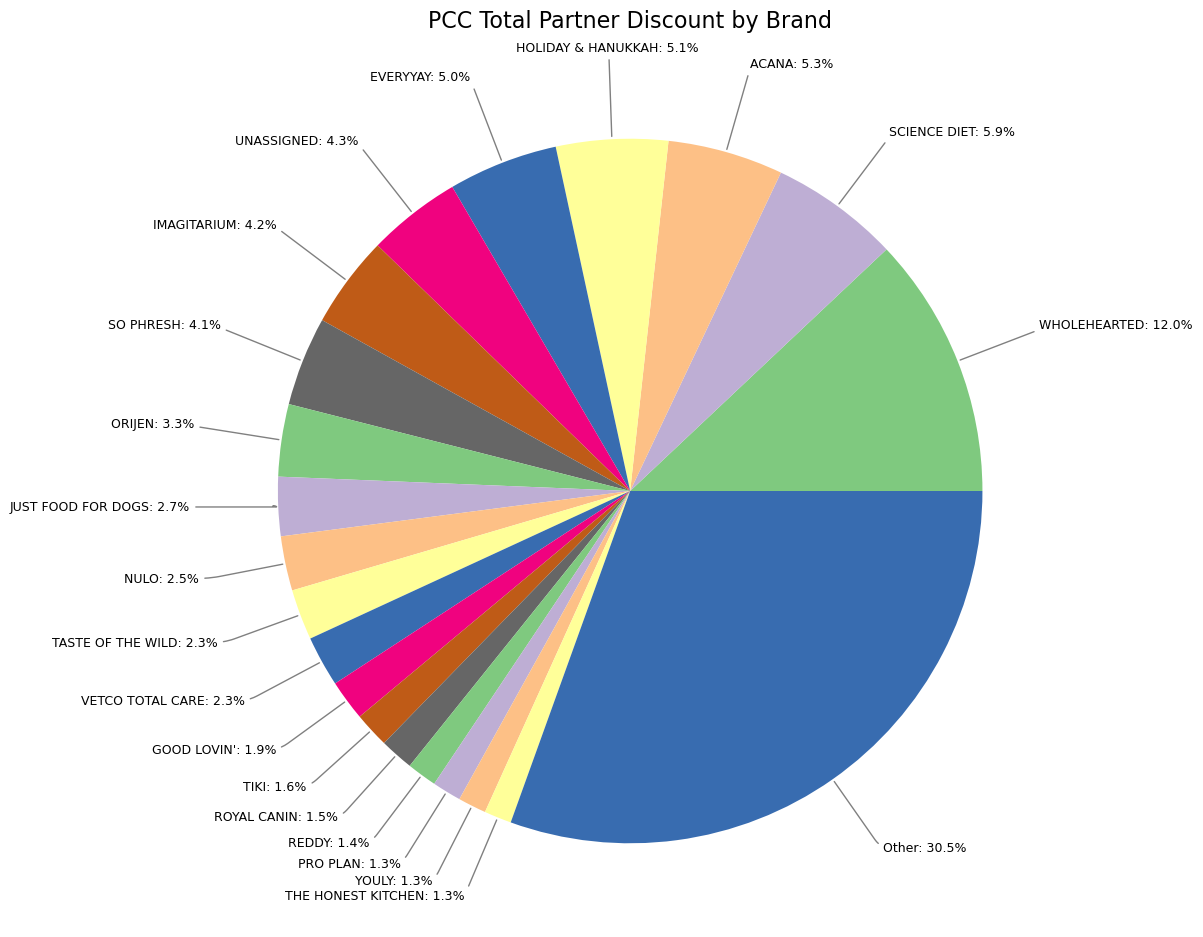

In [353]:
brand_df_pcc = prepare_df_for_graph(brand_df.loc[brand_df['Channel'] == 'PCC'])
draw_pie_chart(brand_df_pcc, 'Total Partner Discount', 'PCC Total Partner Discount by Brand')

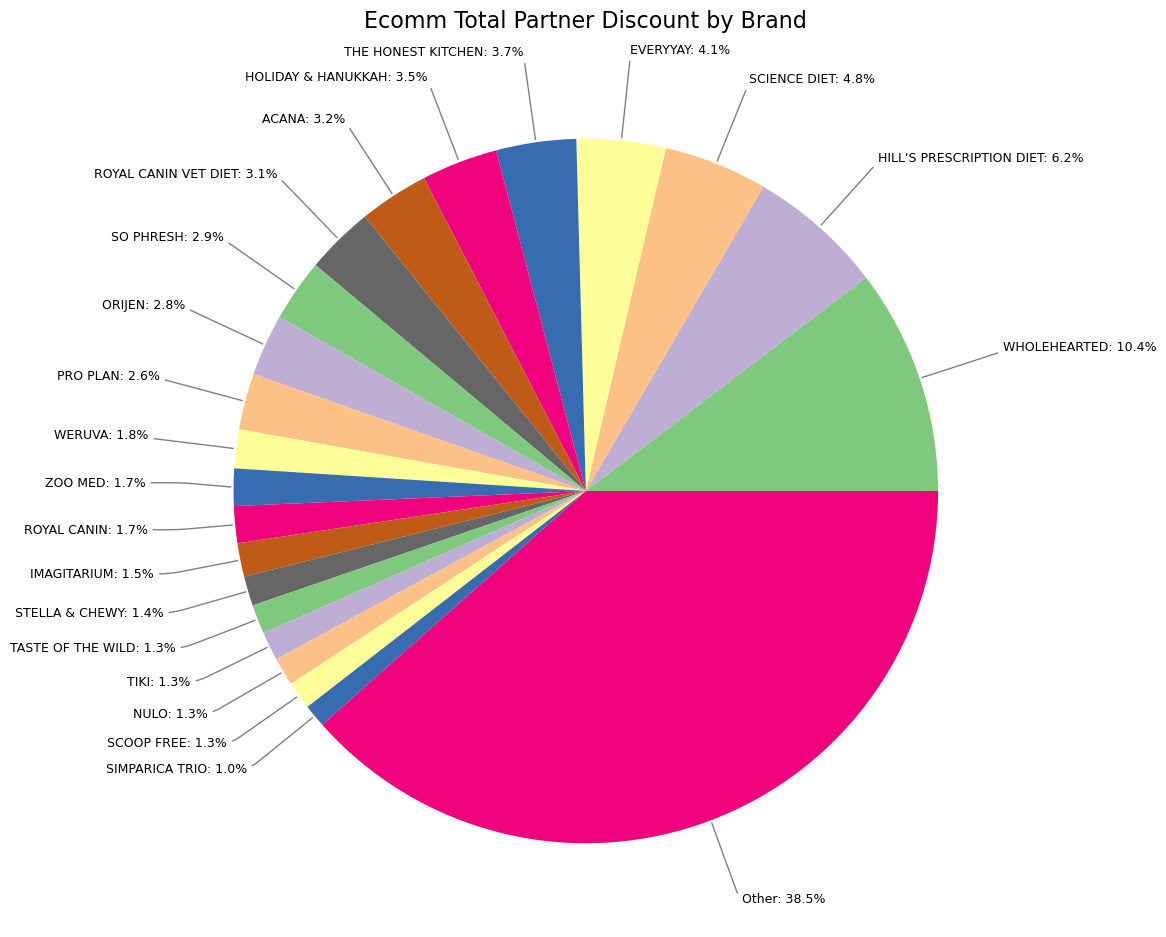

In [354]:
brand_df_ecomm = prepare_df_for_graph(brand_df.loc[brand_df['Channel'] == 'Ecomm'])
draw_pie_chart(brand_df_ecomm, 'Total Partner Discount', 'Ecomm Total Partner Discount by Brand')

In [305]:
from matplotlib.ticker import FuncFormatter
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}K'
def draw_bar_chart(df, title):

    # Set the width of the bars
    bar_width = 0.6

    # Set the positions of the bars
    index = np.arange(len(df['Brand']))

    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the 'Partner Discount & Promo Stacking'
    bars1 = ax.bar(index, df['Partner Discount & Promo Stacking'], bar_width,
                label='Partner Discount & Promo Stacking', color='midnightblue')

    # Plot the 'Partner Discount Only' directly above the first bar
    bars2 = ax.bar(index, df['Partner Discount Only'], bar_width,
                bottom=df['Partner Discount & Promo Stacking'],
                label='Partner Discount Only', color='navajowhite')

    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # Adding the total values on top of the stacks
    for rect1, rect2 in zip(bars1, bars2):
        height = rect1.get_height() + rect2.get_height()
        ax.text(rect1.get_x() + rect1.get_width()/2.0, height, f'{height/1000:.0f}K', ha='center', va='bottom')

    # Adding individual values inside the bars
    for rect in bars1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height/2, f'{height/1000:.0f}K', ha='center', va='center', color='White',fontsize=8)

    for rect in bars2:
        height1 = rect.get_height()
        combined_height = rect.get_y() + height1
        ax.text(rect.get_x() + rect.get_width()/2.0, combined_height - height1/2, f'{height1/1000:.0f}K', ha='center', va='center', color='Black',fontsize=8)

    # Set the labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Brand')
    ax.set_ylabel('Total Partner Discounts')
    ax.set_title(title, pad=20, fontsize = 16,)
    ax.set_xticks(index)
    ax.set_xticklabels(df['Brand'], rotation=45, ha='right', fontsize=10)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


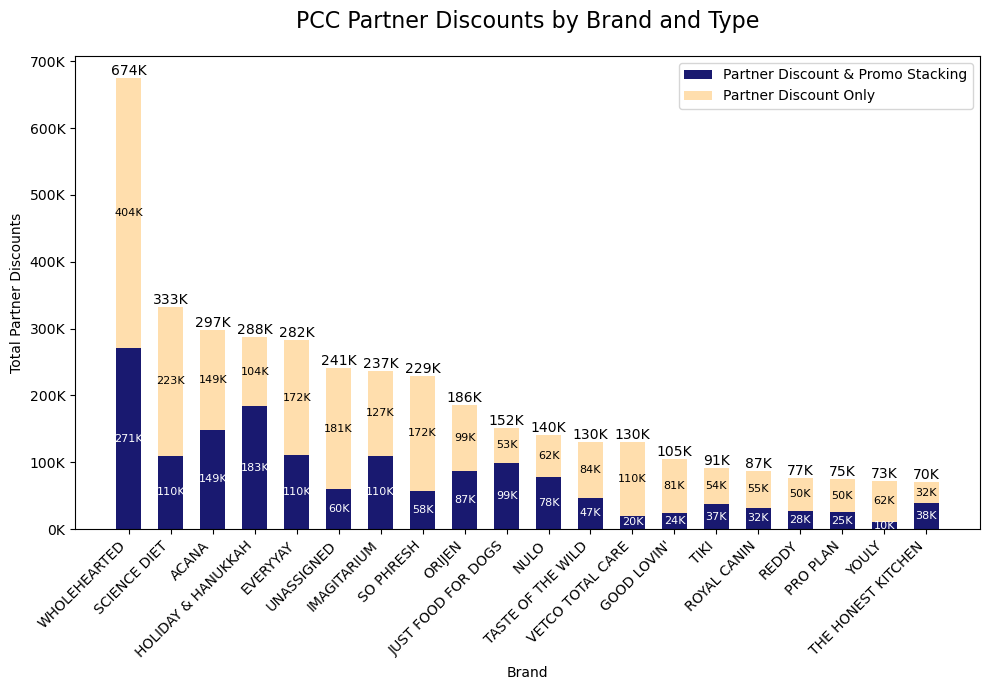

In [306]:
draw_bar_chart(brand_df_pcc.loc[brand_df_pcc['Brand'] != 'Other'], 'PCC Partner Discounts by Brand and Type')

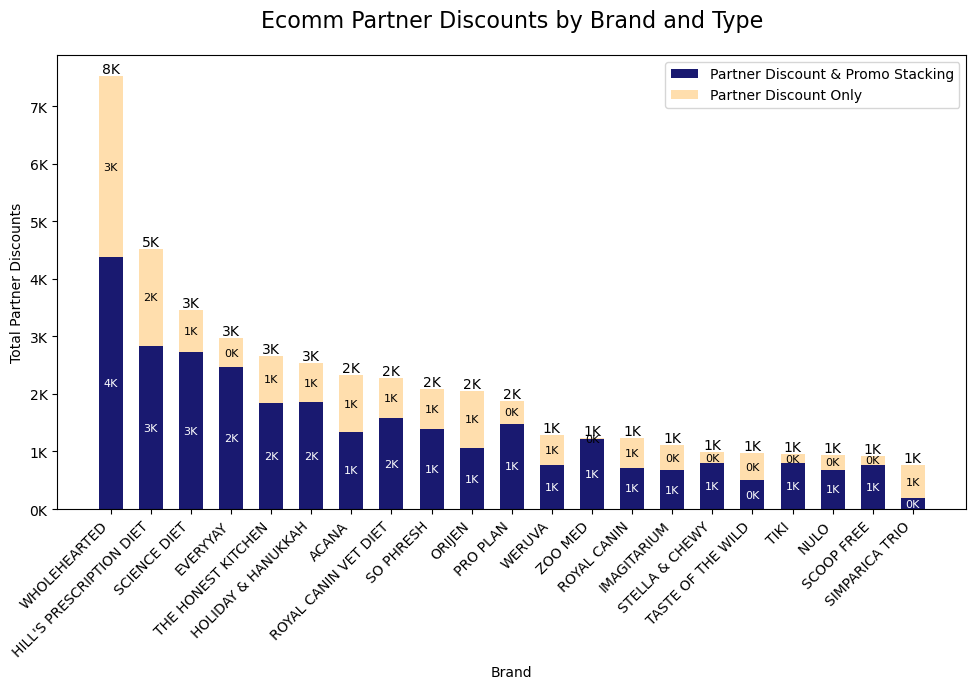

In [308]:
draw_bar_chart(brand_df_ecomm.loc[brand_df_ecomm['Brand'] != 'Other'], 'Ecomm Partner Discounts by Brand and Type')

In [357]:
# Export tables to excel
from openpyxl import load_workbook

In [361]:
def export_to_excel(df_dict, file_path):
    with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
        for sheet_name, df in df_dict.items():
            df.to_excel(writer, sheet_name=sheet_name, index = False)

    wb = load_workbook(file_path)


In [364]:
df_dict = {
            "Summary Table": summary_df,
            "Raw Data": df,
            "Brand Data PCC": brand_df_pcc.drop(columns = ['Individual_Percentage', 'Percentage']) ,
            "Brand Data Ecomm": brand_df_ecomm.drop(columns = ['Individual_Percentage', 'Percentage']) ,
            }


export_to_excel(df_dict, "csv/brand_level_partner_discount_stacking_1.xlsx")